# Deep Learning Graduate Course Competition

*By: Omar Rayyan (olr7742), Mahmoud Hafez (Mah9935), Rameen Mahmoud*

**Importing Required Libraries and Functions**

In [1]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from resnet import ResNet
from utils import get_data_loaders, save_checkpoint, load_checkpoint
from trainer import mixup_train, train, test

**Global Parameters**

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = "data"

**Initializing Our Model (implementation [here](resnet.py))**

In [3]:
model = ResNet(num_blocks=[4,4,3]).to(DEVICE)

**Parameters in our Model**

In [4]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 4697742


**Transforms**

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomAutocontrast(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

**Setting Up Data Loaders**

In [6]:
train_loader, test_loader = get_data_loaders(dataset_path=DATA_PATH,batch_size=128,test_transform=test_transform, train_transform=train_transform)

**Model Hyperparameters**

In [7]:
start_epoch = 0
end_epoch = 250
weight_decay = 0.0005
learning_rate = 0.1
momentum = 0.9

loss_function = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=end_epoch-start_epoch)

**Loading Model Checkpoint**

In [8]:
# load_checkpoint(model, optimizer, "checkpoints/9663.tar")

**Training Model**

In [9]:
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

In [10]:
for epoch in range(start_epoch, end_epoch):
    
    if np.random.rand()<0.9:
        train_loss, train_accuracy = mixup_train(model, optimizer, loss_function, train_loader, DEVICE)
    else:
        train_loss, train_accuracy = train(model, optimizer, loss_function, train_loader, DEVICE)
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    
    test_loss, test_accuracy = test(model, loss_function, test_loader, DEVICE)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)
    
    scheduler.step()
    
    save_checkpoint(model,optimizer,epoch,"checkpoints/my_checkpoint.pth.tar")
    
    print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}, Train accuracy {train_accuracy}, Test accuracy {test_accuracy}')

Epoch 0, Train loss 2.0548749838948557, Test loss 1.6151222156572946, Train accuracy 0.20308, Test accuracy 0.4195


In [20]:
np.save("plots/train_loss_history.npy", train_loss_history)
np.save("plots/train_accuracy_history.npy", train_accuracy_history)
np.save("plots/test_loss_history.npy", test_loss_history)
np.save("plots/test_accuracy_history.npy", test_accuracy_history)

In [15]:
train_loss_history = np.load("plots/train_loss_history.npy")
train_accuracy_history = np.load("plots/train_accuracy_history.npy")
test_loss_history = np.load("plots/test_loss_history.npy")
test_accuracy_history = np.load("plots/test_accuracy_history.npy")

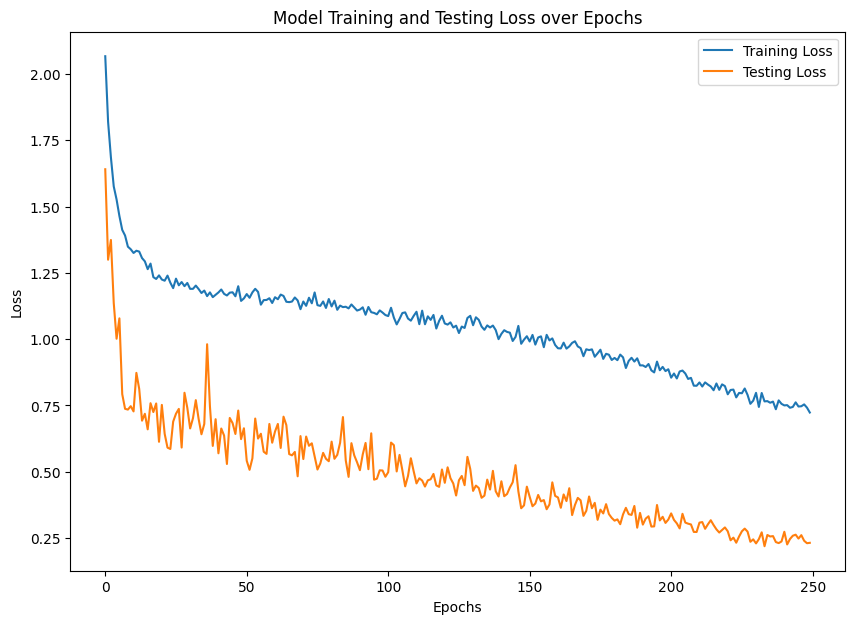

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1223e34c0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


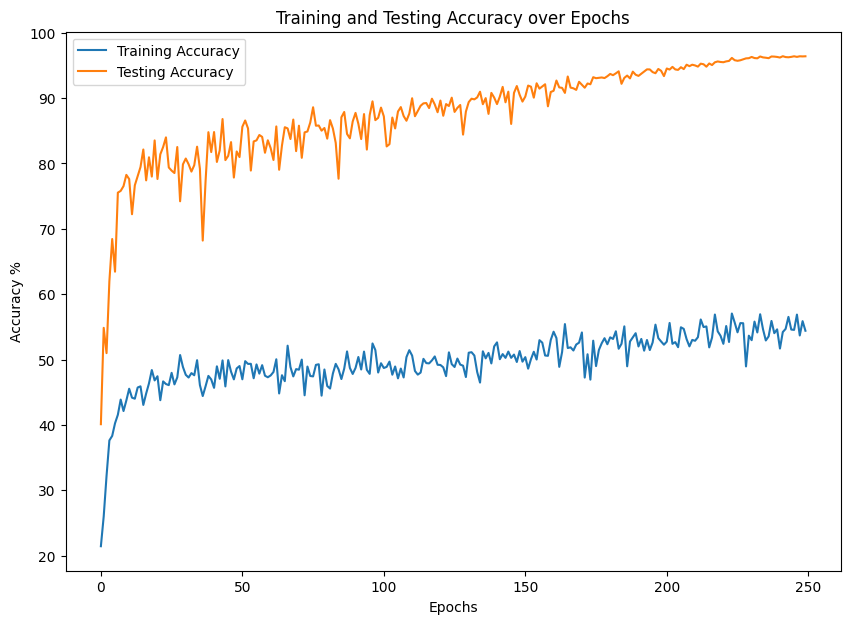

In [16]:
epochs = range(0, len(train_loss_history)) 

# Plotting training and testing losses
plt.figure(figsize=(10, 7))
plt.plot(epochs, train_loss_history, label='Training Loss')
plt.plot(epochs, test_loss_history, label='Testing Loss')
plt.title('Model Training and Testing Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and testing accuracies
plt.figure(figsize=(10, 7))
plt.plot(epochs, train_accuracy_history/0.01, label='Training Accuracy')
plt.plot(epochs, test_accuracy_history/0.01, label='Testing Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.legend()
plt.show()